**Questions**

1.	Name the types of image segmentation or similar things you found on the internet and what made you choose the current approach? Did you try other approaches too? If yes, what were their results? If you read other approaches/research papers/techniques, what is the difference between your approach and others? What are the main highlights about your approach that makes it better than others? It could be anything like your architecture, some connection, some layers, data pre-processing technique, some special loss function, unique training style and so on.
2.	What did you use as a baseline and what were the results? There are lots of metrics but why did you use what you have used? How did you improve further? Did you try anything to improve the existing results? If not, what could you have done?


## Replies

1.

Judging by the nature of the task, (by manual inspection), only a single class of object is to unmasked. Hence it is a task for sementic segmentation of images. Had there been multiple clsses of objects to be distinguished pizelwise, instance segmentation algorithms can be leveraged. In the recent field of development, much attention is pumped into computer vision and its application. And there are alot of methods that have recently comeup. The UNET being the baseline for sementic segmentation tasks, there are multiple flavours of the existing variant like UNET++, which has resnet50 backbone and VNET which has a dense network of skip connections. Also, Autoencoders can be put to task here. There were other similar tasks such as Saliency detection where it is more import to detect where to focus and what to focus-on. 

My approach is (to be fair) rudamentary in compairison the the state of the art methods existant today. But with UNET, the task is handled quite well. In my approach, ive tried to also use Attention mechanism in the skip parts of the UNET and hopefully learn to attend only the regions of interest.

 To addess the low number of training samples, data augmentation techniques have been used but due to slow processing speed of the CPU workers, data augmentation was only left to a single augment of rotation. The data was re normalised across all channels with mean =0.5 and std=0.5, also, after checking all the existing image heights and widths, i had desided to best resise the images to 126 x 126 dims. 


2.

My baseline approach is a UNET with 256 number of channels at the bottleneck.

Second model Ontop of the UNET ive tried self-Attention layers around the skips of the UNET architecture (UNET_Attention) . This didnot seem to increase the accuracy or iou much.  

I have also tried a Fully connected network with parts of resent as its backbone and succesive upsampling layers (convTranspose) to fit the size of the mask. A possible improvement here could be to assign the skip connection directly to the convtranspose layer like in the UNET. 

In, Metrics i was particularly concerned with the intersection over union (jaccard) and the accuracy per pixel. For the loss function , i have tried to train the model with Binary CrossEntropy and DiceLoss which is another way to express iou as a loss function. IOU is a better metric to evaluate since since it is concerned with the region of interest (the intersection) and tries to minimize the overall non intersecting parts of the masks (union). 

Also, I could have tried different augmentation techniques,like random flips, and add gausian noise to the data but this resulted in a very slow input pipeline in colab. Also could try to improve on the existing Attention mechanism on images. Alot could be referenced from Transformer style networks given the proper training environment. I could also have tried to push the accuracy further by re normalising the dataset according to the mean and std of the training data. 

3.

Added thoughts: I took alot of time trying to figure out the new pytorch lightning library and hence could spend more time in EDA and testing of other architectures. Also, tensorflow would have been lot faster for development but I wanted to spend time on the nitty gritty details that pytorch allows. 

Thank you.

#\Read me  :: 

Before running, keep the DUTS_TR file in your root directory. Also mention the path to root in the below code line, . example path is given. If running on colab, uncomment the following lines and import the data to the drive and list the path before carrying on. Enjoy the results. 


## The dicrectory should look like  

root \
>

>-->DUTS_TR \
>>-->DUTS_TR_Images \
>>-->DUTS_TR_masks\

>-->Training.ipynb\
>-->Testing.ipynb\
>-->model1.ckpt\
>-->model2.ckpt\
>-->model3.ckpt


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
root_dir = "/content/drive/MyDrive/DigitalStudio_Assignment"

In [4]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F

from torch.utils.data import DataLoader,Dataset, random_split
import random
import torchvision
from torchvision import datasets, transforms
import os
import torchvision.transforms.functional as tvf
import glob

from sklearn.model_selection import train_test_split
from tqdm import tqdm

from PIL import Image, ImageOps
#import torch_xla
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint

import torchmetrics

import matplotlib.pyplot as plt

In [6]:

class Transforms(nn.Module):

  def __init__(self,n_mean =[0.5]*3,n_std=[0.5]*3 ):
    super().__init__()
    
    self.normalize = torchvision.transforms.Normalize(n_mean,n_std)

  def forward(self,images,masks):

    images = self.normalize(images)
    # if torch.rand([1]) > 0.5:
    #     image = tvf.hflip(images)
    #     mask = tvf.hflip(masks)
    if torch.rand([1]) > 0.5:
            angle = torch.randint(-30,30,[1])
            images = tvf.rotate(images, int(angle))
            masks = tvf.rotate(masks, int(angle))

    return images,masks


class MyTrainDataset(Dataset):
    def __init__(self, image_paths, target_paths, train=True,*args):

        self.image_paths = image_paths
        self.target_paths = target_paths
        self.tr2 = Transforms()

    def transforms(self,images,masks,index):
        images= images.resize((126,126))
        masks= masks.resize((126,126))
        images = transforms.ToTensor()(images)
        masks = transforms.ToTensor()(masks)
        image, masks = self.tr2(images,masks)

        return images,masks
    def __getitem__(self, index):

        
        images = Image.open(self.image_paths[index])
        masks = Image.open(self.target_paths[index]).convert('1')

        images,masks = self.transforms(images,masks,index)
        return images,masks

    def __len__(self):
        return len(self.image_paths)

#iou metric taken from Kaggle. url : https://www.kaggle.com/code/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy/script
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    
    SMOOTH = 1e-6
    outputs = outputs.int()
    labels = labels.int()
    if len(outputs.shape)==4 : # means will have channel
      outputs = outputs.squeeze(1)  # BATCH x 1 x H x W => BATCH x H x W
    if len(labels.shape)==4 : # means will have channel
      labels = labels.squeeze(1) 
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
    return thresholded.mean()

class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()
        self.smooth = 1e-6

    def forward(self, inputs, targets):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + self.smooth)/(inputs.sum() + targets.sum() + self.smooth)  
        
        return 1 - dice    

def accuracy_score(logits,targets):
  logits = logits.view(-1)
  targets = targets.view(-1)
  correct = (logits==targets).sum()
  return correct/torch.numel(logits)

class Seg_Model_Trainer(pl.LightningModule):

  def __init__(self,model):
      super().__init__()
      self.DICE_loss = DiceLoss()
      self.BCE_with_logits = nn.BCEWithLogitsLoss()
      self.model = model
      self.SMOOTH = 1e-6
      self.iou = torchmetrics.JaccardIndex(num_classes=2)

  def forward(self, x):
      batch_size, channels, width, height = x.size()
      x = self.model(x)
      return x

    
  def cross_entropy_loss(self, logits, labels):
      return self.NLL(logits, labels)
    
  def combined_loss(self,logits,labels):
      B = 2
      # loss = self.BCE(logits,labels) - B*(torch.log(self.DICE_loss(logits,labels)))
      loss = self.DICE_loss(logits,labels)
      return loss

      

  def training_step(self, train_batch, batch_idx):
      x, y = train_batch
      logits = self.forward(x)
      loss = self.combined_loss(logits, y)

      self.log('train_loss', loss)
      return loss

  def validation_step(self, val_batch, batch_idx):
      x, y = val_batch
      logits = self.forward(x)
      loss = self.combined_loss(logits, y)
      preds,targets = (torch.sigmoid(logits)>0.5).int(),y.int()
      metric1 = self.iou(preds,targets)
      metric2 = accuracy_score(preds,targets)
      self.log('val_loss', loss)
      self.log('IOU', metric1)
      self.log('Accuracy', metric2)
  def configure_optimizers(self):
      optimizer = torch.optim.Adam(self.parameters(), lr=1e-2)
      return optimizer


def accuracy_score(logits,targets):
  logits = logits.view(-1)
  targets = targets.view(-1)
  correct = (logits==targets).sum()
  return correct/torch.numel(logits)


def visualize(model,dataloader,n= 4):
  # device = 'cuda' if model.device()=='cuda' else 0
  # model = model.device(device)
  samples = 0

  fig, axes = plt.subplots(n, 3, sharex='col', sharey='row')
  fig.subplots_adjust(hspace=0.4, wspace=0.4)
  with torch.no_grad():
    for ax in axes:
      for images,masks in dataloader:
        if random.random()>0.7:
          
          # image = image.cude() if device ==1 else image
          preds = torch.sigmoid(model(images))
          image,mask,pred = images[0],masks[0],preds[0]
          image,mask,pred = image.permute(1,2,0).numpy(),mask.squeeze().numpy(),pred.squeeze().numpy()
          i = (0)*3
          ax[i+0].imshow(image)
          ax[i+0].set_title("Image")  
          ax[i+1].imshow(mask,cmap="binary")
          ax[i+1].set_title("Mask") 
          ax[i+2].imshow(pred,cmap="binary")
          ax[i+2].set_title("Prediction")
          samples +=1
          break
  
 
  plt.show()
  return

def overfit_on_single_eg(model,dataset,epochs):
  train_dataloader = DataLoader(dataset,batch_size = 1,shuffle=False,num_workers=1)
  opt = torch.optim.Adam(model.parameters(), lr=1e-2)
  loss =  nn.BCELoss()
  loss_metric = torchmetrics.JaccardIndex(num_classes=2)
  image,mask = next(iter(train_dataloader))
  model.train()
  fig, axes = plt.subplots(1, 3, sharex='col', sharey='row')
  for e in range(epochs):
    
      logits = model(image)
      logits = torch.sigmoid(logits).float()
      mask = mask.float()
      opt.zero_grad()
      l1 = loss(logits,mask)
      l1.backward()
      opt.step()
     
      logits,mask = (logits>0.5).int(),mask.int()
      l2 = loss_metric(logits,mask)
      l3 = accuracy_score(logits,mask)
      print(f"DICE loss:  {l1},    IOU = {l2},  Accuracy: {l3}")
  axes[0].imshow(image[0].detach().permute(1,2,0).numpy())
  axes[1].imshow(mask[0].detach().squeeze().numpy(),cmap='binary')
  axes[2].imshow(logits[0].detach().squeeze().numpy(),cmap='binary')

  model.eval()  
  return

class DoubleConv(nn.Module):

  def __init__(self,in_chnl,out_chnl):
    super().__init__()
    self.seq = nn.Sequential(
        nn.Conv2d(in_chnl, out_chnl, kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(out_chnl),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_chnl, out_chnl, kernel_size=3,stride=1,padding=1,bias=False),
        nn.BatchNorm2d(out_chnl),
        nn.ReLU(inplace=True),
    )
  def forward(self,x):
    x = self.seq(x)
    return x



class UNET(nn.Module):
  def __init__(self):
    super().__init__()
    in_channels=3
    out_channels=1
    channels = [32,64,128]

    self.downs = nn.ModuleList()
    self.ups = nn.ModuleList()
    for channel in channels:
      self.downs.append(DoubleConv(in_channels,channel))
      in_channels= channel
    
    for channel in reversed(channels):
      self.ups.append(nn.ConvTranspose2d(channel*2,channel,kernel_size=2,stride=2))
      self.ups.append(DoubleConv(channel*2,channel))
    
    self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
    self.bottleneck = DoubleConv(channels[-1],channels[-1]*2)
    self.final_conv = nn.Conv2d(channels[0],out_channels,kernel_size=1)


  def forward(self,x):
    skips = []
    for down in self.downs:
      x = down(x)
      skips.append(x)
      x = self.maxpool(x)
    
    x = self.bottleneck(x)
    
    skips = skips[::-1]
    for idx in range(0,len(self.ups),2):
      x =self.ups[idx](x)
      skip_x = skips[idx//2]
      if skip_x.shape != x.shape:
        x = tvf.resize(x, size=skip_x.shape[2:])
      x = torch.cat((skip_x,x),dim=1)
      x = self.ups[idx+1](x)
    
    x = self.final_conv(x)
    return x


class ConvAttention(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self,key,query):
    score = torch.multiply(key,query)
    dk = torch.numel(score)

    weights = torch.softmax(score/dk,dim=1)

    # key = 65 x 22 x 22
    # value = 65 x 22 x 22
    #value
    context = key*weights 
    return context

class UNET_2(nn.Module):
  def __init__(self):
    super().__init__()
    in_channels=3
    out_channels=1
    channels = [16,32,64]

    self.downs = nn.ModuleList()
    self.ups = nn.ModuleList()
    for channel in channels:
      self.downs.append(DoubleConv(in_channels,channel))
      in_channels= channel
    
    for channel in reversed(channels):
      self.ups.append(nn.ConvTranspose2d(channel*2,channel,kernel_size=2,stride=2))
      self.ups.append(ConvAttention())
      self.ups.append(DoubleConv(channel*2,channel))
    
    self.maxpool = nn.MaxPool2d(kernel_size=2,stride=2)
    self.bottleneck = DoubleConv(channels[-1],channels[-1]*2)
    self.final_conv = nn.Conv2d(channels[0],out_channels,kernel_size=1)


  def forward(self,x):
    skips = []
    for down in self.downs:
      x = down(x)
      skips.append(x)
      x = self.maxpool(x)
    
    x = self.bottleneck(x)
    
    skips = skips[::-1]
    for idx in range(0,len(self.ups),3):
      x =self.ups[idx](x)
      skip_x = skips[idx//3]
      if skip_x.shape != x.shape:
        x = tvf.resize(x, size=skip_x.shape[2:])
      
      skip_x = self.ups[idx+1](skip_x,x)
      x = torch.cat((skip_x,x),dim=1)
      x = self.ups[idx+2](x)
    
    x = self.final_conv(x)
    return x


In [13]:
import torchvision.models as models

class FCN(nn.Module):
  def __init__(self,model):
    super().__init__()
    self.model=model
    self.convT1 = nn.Sequential(nn.ConvTranspose2d(in_channels =128,out_channels=64,kernel_size = 2,stride=2,dilation=1), nn.ReLU(inplace=True))
    self.batchnorm1 = nn.BatchNorm2d(64)
    self.convT2 = nn.Sequential(nn.ConvTranspose2d(in_channels =64,out_channels=32,kernel_size = 2,stride=2,dilation=1), nn.ReLU(inplace=True))
    self.batchnorm2 = nn.BatchNorm2d(32)
    self.convT3 = nn.Sequential(nn.ConvTranspose2d(in_channels =32,out_channels=8,kernel_size = 2,stride=2,dilation=1,padding=1), nn.ReLU(inplace=True))
    self.convfinal =  nn.Sequential(nn.ConvTranspose2d(in_channels =8,out_channels=1,kernel_size = 1,stride=1,dilation=1))                        
  def forward(self,x):
    
    for module in self.model:
      x = module(x)

    x = self.convT1(x)
    x = self.batchnorm1(x)

 
    x = self.convT2(x)
    x = self.batchnorm2(x)

    x = self.convT3(x)
    
    x = self.convfinal(x)
    return x




# taking 5 of the first child layers of the resent18 
resnet = models.resnet18(pretrained=True)
new_mod = nn.ModuleList()
layers =resnet.children()
for e,child in enumerate(layers):
  
  child.requires_grad = False
  new_mod.append(child)
  if e == 5:
    break

    

In [8]:
# get the files 
path  = f"{root_dir}/DUTS-TR"
BATCH =16
masks =  glob.glob(f"{path}/DUTS-TR-Mask/*.png")
images = glob.glob(f"{path}/DUTS-TR-Image/*.jpg")
masks.sort()
images.sort()


test_images , test_masks = images[-423:], masks[-423:]
# val_images, test_images, val_masks, test_masks = train_test_split(val_images,val_masks,shuffle=True,test_size=0.4)


print(f"Testing samples:{len(test_images)}")



test_data = MyTrainDataset(test_images,test_masks)



test_dataloader = DataLoader(test_data,batch_size =BATCH,shuffle=False)


Testing samples:423


In [9]:
trainer = pl.Trainer()


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  category=PossibleUserWarning,
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Missing logger folder: /content/lightning_logs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:498: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Accuracy            0.9260726571083069
           IOU               0.831459641456604
        val_loss            0.21712800860404968
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


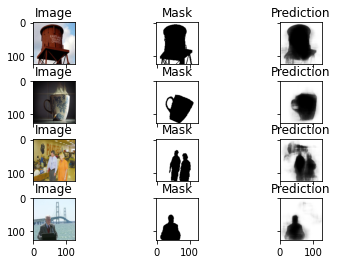

In [10]:
unet= Seg_Model_Trainer.load_from_checkpoint(checkpoint_path=f"{root_dir}/unet[256]-epoch=25-val_loss=0.22.ckpt",model=UNET())

trainer.validate(unet,dataloaders=test_dataloader) 

visualize(unet, test_dataloader,n=4)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:498: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Accuracy            0.9141947627067566
           IOU               0.80785071849823
        val_loss            0.15892191231250763
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


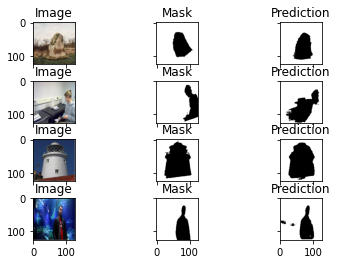

In [11]:

unet2 = Seg_Model_Trainer.load_from_checkpoint(checkpoint_path=f"{root_dir}/unet[attention]-epoch=37-val_loss=0.16.ckpt",model=UNET_2())


trainer.validate(unet2,dataloaders=test_dataloader) 

visualize(unet2, test_dataloader,n=4)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:498: PossibleUserWarning: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test/predict dataloaders.
  category=PossibleUserWarning,


Validation: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Accuracy            0.8814724087715149
           IOU              0.7410946488380432
        val_loss            0.3047008514404297
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


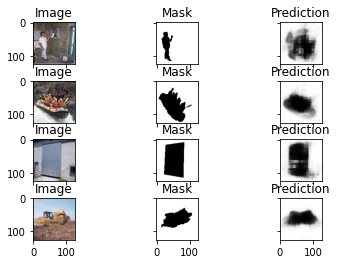

In [14]:
fcn = Seg_Model_Trainer.load_from_checkpoint(checkpoint_path=f"{root_dir}/fcn[resnet]-epoch=09-val_loss=0.23.ckpt",model=FCN(new_mod))

trainer.validate(fcn,dataloaders=test_dataloader) 

visualize(fcn, test_dataloader,n=4)